In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from msc_filtering import MyKalmanFilterZeroOrder, MyKalmanFilterHigherOrder

## Some theory

#### State space processes

The discrete linear time invariant (LTI) state-space process model defines the evolution of the state from time k−1 to time k  as:

$x_k=Fx_{k−1}+Bu_{k−1}+w_{k}$

$x$: state vector (n x 1)<br> 
$F$: state transition matrix (n x n) <br> 
$u$: control vector <br> 
$B$: control-input matrix <br> 
$w$: process noise vector (n x 1) $w \sim N(0,Q)$ -> $Q$ (n x n)

The measurement/observation model describes the relationship between the state and the measurement at the current time step $k$

$z_k=Hx_{k}+{\upsilon}_k$

$z$: measurement vector. This is the measured value (m x 1) <br> 
$H$: measurement matrix (m x n)<br> 
$\upsilon$: measurement noise vector (m x 1) $\upsilon \sim N(0,R)$ -> $R$ (m x m)

$F$ is a discretised process which can be found from a continous linear first order state space model using the infinite sum:

From: <br>
$\dot{x} = A \cdot x $

One can find:<br>
$F_t = e^{{\Delta}tA} = I + \sum_{i=1}^{\infty}\frac{{\Delta}t^iA^i}{i!} $ <br>
- Where $I$ is the identity matrix
- $x_1 = x_0 e^{A{\Delta}t}$ is the solution to a first order differential equation
- Using Taylor series expansion:
$e^x= 1 + \sum_{i=1}^{\infty}\frac{x^i}{i!} $ -> describes/approximates the local region around a function

If you take a differential equation and discretize it in order to solve it numerically you will end up with a difference equation (difference between two consecutive values - can use to create a corresponding recursive equation) 

Note the equivalence to Newtonian equations: <br>
$x_t = x_{t-1} + v\Delta t$ <br>
$v_t = v_{t-1}$

#### Standard kalman filter

Initialise: <br>
$x_{0|0}$ -> The "previous value of x" initialised to the starting value <br>
$P_{0|0}$ -> The error covariance (Uncertainty of the estimate). Variance is $\sigma^2$ <br>
When a relatively large error covaraiance is used for initialisation, the system tends towards using the first measurement as the new state (rather than the initial value of x) and converges over time.

Prediction from action model: <br>
$x_{t|t-1}=Fx_{t-1|t-1}+Bu_{t-1|t-1}$ -> The expected value of x (intermediate) <br>
$P_{t|t-1}=FP_{t−1}F^T+Q$ -> The uncertainty of the estimate growth by dynamics and noise. <br>
Where $x_{t-1|t-1}$ is known as the prior estimate

Compute optimal Kalman gain: <br>
$K = P_{t|t-1}H^T(HP_{t|t-1}H^T+R)^{-1}$ -> (n x m) Trade off between prediction and measurements. Relatively large measurement noise leads to smaller gain. 

Correction from sensor: <br>
$x_{t|t}=x_{t|t−1}+K(z_t-Hx_{t|t-1})$ -> Lower gain emphesizes measurements less. The measurement residual is also known as the "innovation" term, which is the difference between the actual measurement and the expected measurement <br>
$P_{t|t}=(I-KH)P_{t|t-1}$ -> The uncertainty estimate shrinks based on observations. This is the variance of the optimium combined estimate

Order refers to the number of derivatives needed to model the system accurately. When the Kalman filter is of higher order than your physical process it also has an infinite number of solutions to choose from (overfitting) therefore the filter order should correspond to the problem

## Try Kalman filtering

####  Constant process with zero order filter (constant model)

Ball with constant position at L=1

Define kalman filter params

In [2]:
x0 = 0  # Initial value - arbitrary guess
p0 = 1000  # State covariances (Error of estimation) - Init high since unknown
Q = 0.0001  # System noise
R = 0.1  # Measurement noise

Instantiate filter

In [3]:
testFilter_const = MyKalmanFilterZeroOrder(x0, p0, R, Q)

Evaluate against synthetic data

In [4]:
%%capture
xt_intr_list = []
Pt_intr_list = []
k_gain_list = []
xt_curr_list = []
Pt_curr_list = []

measure_list = [0.9, 0.8, 1.1, 1, 0.95, 1.05, 1.2, 0.9, 0.85, 1.15]
for measure in measure_list:
    testFilter_const.step(measure);
    xt_intr_list.append(testFilter_const.xt_intr)
    Pt_intr_list.append(testFilter_const.Pt_intr)
    k_gain_list.append(testFilter_const.k_gain)
    xt_curr_list.append(testFilter_const.xt_curr)
    Pt_curr_list.append(testFilter_const.Pt_curr)

Check results

In [5]:
list_of_lists = [xt_intr_list,Pt_intr_list,k_gain_list,xt_curr_list,Pt_curr_list]
df_level = pd.DataFrame(list(zip(*list_of_lists)), columns= ['xt_intr','Pt_intr','k_gain','xt_curr','Pt_curr'])

In [6]:
df_level

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,0.000000,1000.000100,0.999900,0.899910,0.099990
1,0.899910,0.100090,0.500225,0.849933,0.050022
2,0.849933,0.050122,0.333877,0.933424,0.033388
3,0.933424,0.033488,0.250867,0.950126,0.025087
4,0.950126,0.025187,0.201193,0.950101,0.020119
5,0.950101,0.020219,0.168187,0.966902,0.016819
6,0.966902,0.016919,0.144705,1.000633,0.014470
7,1.000633,0.014570,0.127175,0.987835,0.012717
8,0.987835,0.012817,0.113613,0.972175,0.011361
9,0.972175,0.011461,0.102827,0.990460,0.010283


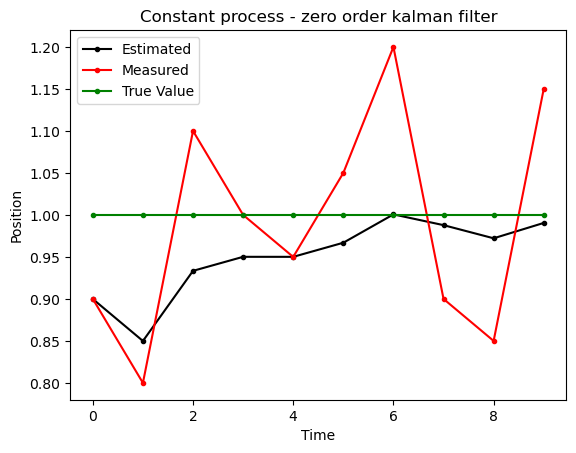

In [7]:
plt.plot(df_level.index, df_level['xt_curr'] ,marker=".",color="black")
plt.plot(df_level.index, measure_list ,marker=".",color="red")
plt.plot(df_level.index, np.ones(len(df_level.index)) ,marker=".",color="g")
plt.title("Constant process - zero order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.show()

#### Constant increasing process with zero order filter

Ball with constant motion 0.1 per step

In [8]:
rising_level = 0
gt_level = []

steps = 6
for _ in range(steps):
    rising_level = rising_level + 0.1
    gt_level.append(rising_level)

In [9]:
gt_level

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6]

Define kalman filter params

In [10]:
x0 = 0  # Initial value - arbitrary guess
p0 = 1000  # State covariances (Error of estimation) - High since unknown
Q = 0.001  # System noise
R = 0.1  # Measurement noise

Instantiate filter

In [11]:
testFilter_rising = MyKalmanFilterZeroOrder(x0, p0, R, Q)

Evaluate against synthetic data

In [12]:
%%capture
xt_intr_list = []
Pt_intr_list = []
k_gain_list = []
xt_curr_list = []
Pt_curr_list = []

measure_list = [0.11, 0.29, 0.32, 0.5, 0.58, 0.54]
for measure in measure_list:
    testFilter_rising.step(measure);
    
    # Record time steps    
    xt_intr_list.append(testFilter_rising.xt_intr)
    Pt_intr_list.append(testFilter_rising.Pt_intr)
    k_gain_list.append(testFilter_rising.k_gain)
    xt_curr_list.append(testFilter_rising.xt_curr)
    Pt_curr_list.append(testFilter_rising.Pt_curr)

Check results

In [13]:
list_of_lists = [xt_intr_list,Pt_intr_list,k_gain_list,xt_curr_list,Pt_curr_list]
df_rising_level = pd.DataFrame(list(zip(*list_of_lists)), columns= ['xt_intr','Pt_intr','k_gain','xt_curr','Pt_curr'])

In [14]:
df_rising_level

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,0.000000,1000.001000,0.999900,0.109989,0.099990
1,0.109989,0.100990,0.502463,0.200438,0.050246
2,0.200438,0.051246,0.338827,0.240949,0.033883
3,0.240949,0.034883,0.258615,0.307943,0.025861
4,0.307943,0.026861,0.211739,0.365548,0.021174
5,0.365548,0.022174,0.181494,0.397210,0.018149


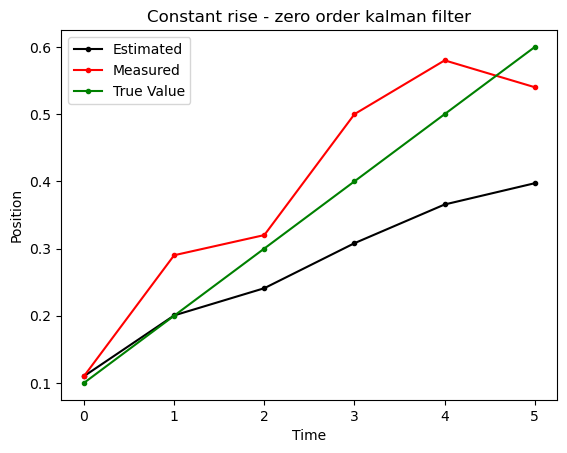

In [15]:
plt.plot(df_rising_level.index, df_rising_level['xt_curr'] ,marker=".",color="black")
plt.plot(df_rising_level.index, measure_list ,marker=".",color="red")
plt.plot(df_rising_level.index, gt_level ,marker=".",color="g")
plt.title("Constant rise - zero order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.show()

#### Constant increasing process with first order filter (aka constant velocity model)

Using a sampling rate of $\Delta t= 1$

In [16]:
delta_t = 1

In [17]:
X0 = np.array([0,0])  # Level, Filling rate
P0 = np.array([[1000,0],[0, 1000]])  # Assume no correlation between states
F = np.array([[1, delta_t], [0, 1]])
r = 0.3
q = 0.00001
Q = np.array([[((delta_t**3)*q)/3,((delta_t**2)*q)/2],
              [((delta_t**2)*q)/2,((delta_t)*q)]])
H = np.array([1, 0])

In [18]:
testFilter_filling = MyKalmanFilterHigherOrder(X0, P0, r, Q, F, H)

In [19]:
#%%capture
xt_intr_list = []
Pt_intr_list = []
k_gain_list = []
xt_curr_list = []
Pt_curr_list = []

measure_list = [0.3, 0.45, 0.2, 0.48, 0.75, 0.6]
for measure in measure_list:
    testFilter_filling.step(measure);
    
    # Record time steps    
    xt_intr_list.append(testFilter_filling.xt_intr)
    Pt_intr_list.append(testFilter_filling.Pt_intr)
    k_gain_list.append(testFilter_filling.k_gain)
    xt_curr_list.append(testFilter_filling.xt_curr)
    Pt_curr_list.append(testFilter_filling.Pt_curr)

In [20]:
list_of_lists = [xt_intr_list,Pt_intr_list,k_gain_list,xt_curr_list,Pt_curr_list]
df_filling = pd.DataFrame(list(zip(*list_of_lists)), columns= ['xt_intr','Pt_intr','k_gain','xt_curr','Pt_curr'])

In [21]:
df_filling

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,"[0, 0]","[[2000.0000033333333, 1000.000005], [1000.0000...","[0.9998500224968755, 0.4999250129148544]","[0.2999550067490626, 0.14997750387445632]","[[0.2999550067489447, 0.14997750387439737], [0..."
1,"[0.4499325106235189, 0.14997750387445632]","[[0.7498908524553577, 0.29996000849868226], [0...","[0.7142560111859283, 0.2857058977103878]","[0.44998071531636175, 0.14999678598734978]","[[0.21427680335577842, 0.08571176931311632], [..."
2,"[0.5999775013037115, 0.14999678598734978]","[[0.4285617031589566, 0.1285747971567285], [0....","[0.5882297975597183, 0.17647756751314753]","[0.36469881668338733, 0.07940972949728398]","[[0.1764689392679155, 0.052943270253944255], [..."
3,"[0.4441085461806713, 0.07940972949728398]","[[0.3000105896125172, 0.07060004675732409], [0...","[0.5000088245213505, 0.11766466789014028]","[0.46205458981523617, 0.0836328854910296]","[[0.15000264735640517, 0.035299400367042086], ..."
4,"[0.5456874753062657, 0.0836328854910296]","[[0.22943551381878877, 0.04413513276200815], [...","[0.4333587525398197, 0.08336262228361659]","[0.6342280961358036, 0.10066491331488545]","[[0.1300076257619459, 0.025008786685084973], [..."
5,"[0.734893009450689, 0.10066491331488545]","[[0.18503805609819438, 0.030023310317830176], ...","[0.3814918309435374, 0.061898875645650484]","[0.6834324282938617, 0.09231518769742969]","[[0.11444754928306122, 0.018569662693695147], ..."


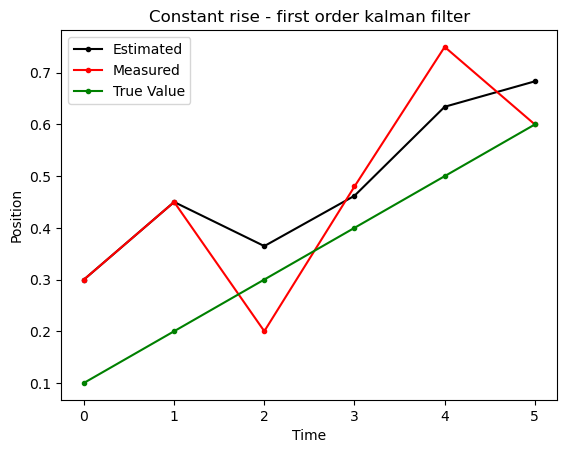

In [22]:
plt.plot(df_filling.index, np.stack((df_filling['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.plot(df_filling.index, measure_list ,marker=".",color="red")
plt.plot(df_filling.index, gt_level ,marker=".",color="g")
plt.title("Constant rise - first order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.show()

When P is initialised high - the measurements are used rather then the proposed initial values

#### Parabolic process with first order filter

In [54]:
steps = np.arange(60)
para_gt = -0.01*(steps-30)**2+10
para_measure = para_gt+2*(np.random.rand(para_gt.shape[0])-0.5)

Using a sampling rate of $\Delta t= 1$

In [55]:
delta_t = 1

In [56]:
X0 = np.array([0,0])  # Level, Filling rate
P0 = np.array([[1000,0],[0, 1000]])  # Assume no correlation between states
F = np.array([[1, delta_t], [0, 1]])
r = 0.3
q = 0.0000001
Q = np.array([[((delta_t**3)*q)/3,((delta_t**2)*q)/2],
              [((delta_t**2)*q)/2,((delta_t)*q)]])
H = np.array([1, 0])

In [57]:
testFilter_para = MyKalmanFilterHigherOrder(X0, P0, r, Q, F, H)

In [58]:
#%%capture
xt_intr_list = []
Pt_intr_list = []
k_gain_list = []
xt_curr_list = []
Pt_curr_list = []

for measure in para_measure:
    testFilter_para.step(measure);
    
    # Record time steps    
    xt_intr_list.append(testFilter_para.xt_intr)
    Pt_intr_list.append(testFilter_para.Pt_intr)
    k_gain_list.append(testFilter_para.k_gain)
    xt_curr_list.append(testFilter_para.xt_curr)
    Pt_curr_list.append(testFilter_para.Pt_curr)

In [59]:
list_of_lists = [xt_intr_list,Pt_intr_list,k_gain_list,xt_curr_list,Pt_curr_list]
df_para = pd.DataFrame(list(zip(*list_of_lists)), columns= ['xt_intr','Pt_intr','k_gain','xt_curr','Pt_curr'])

In [60]:
df_para

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,"[0, 0]","[[2000.0000000333334, 1000.00000005], [1000.00...","[0.999850022496628, 0.4999250112649782]","[1.268021570571455, 0.6340107853068612]","[[0.2999550067489564, 0.14997750337947746], [0..."
1,"[1.9020323558783163, 0.6340107853068612]","[[0.7498875502282211, 0.2999550567664538], [0....","[0.7142551124310532, 0.2857020799048913]","[1.6522199051271953, 0.5340857927886971]","[[0.21427653372931596, 0.08571062397146739], [..."
2,"[2.186305697915892, 0.5340857927886971]","[[0.42855314842325565, 0.12856600738913904], [...","[0.5882249625174718, 0.17646757503880572]","[2.652712661195566, 0.6740079501873346]","[[0.17646748875524157, 0.052940272511641726], ..."
3,"[3.3267206113829006, 0.6740079501873346]","[[0.29999486481375004, 0.07058712021353346], [...","[0.4999957206414995, 0.11764620724786545]","[3.244767637128438, 0.6547248719614862]","[[0.14999871619244984, 0.03529386217435964], [..."
4,"[3.8994925090899244, 0.6547248719614862]","[[0.22940999824285002, 0.044117436542707195], ...","[0.43333144255733436, 0.08333321374574744]","[3.946812956912272, 0.6638249847288685]","[[0.12999943276720027, 0.02499996412372423], [..."
5,"[4.610637941641141, 0.6638249847288685]","[[0.18499946484020954, 0.03000008461595169], [...","[0.3814426164390933, 0.06185591282216296]","[4.45614428967873, 0.6387718169507727]","[[0.11443278493172797, 0.018556773846648885], ..."
6,"[5.094916106629503, 0.6387718169507727]","[[0.15463925833538975, 0.021649716223679557], ...","[0.3401361750007773, 0.047619548525016396]","[4.978040715452612, 0.6224090958685017]","[[0.1020408525002332, 0.01428586455750492], [0..."
7,"[5.600449811321114, 0.6224090958685017]","[[0.13265356872917727, 0.016326868338105816], ...","[0.3066045869419669, 0.03773658538415002]","[5.0558696491687884, 0.5553827151070644]","[[0.09198137608259006, 0.011320975615245005], ..."
8,"[5.6112523642758525, 0.5553827151070644]","[[0.11603861797568682, 0.012736282944518422], ...","[0.27891309354957067, 0.030613222893800515]","[5.399303385114937, 0.5321194066026417]","[[0.08367392806487119, 0.009183966868140154], ..."
9,"[5.931422791717579, 0.5321194066026417]","[[0.10306249077257254, 0.010204612506227864], ...","[0.25569854087644545, 0.025317693260586242]","[6.0319969947942464, 0.542077644200303]","[[0.07670956226293363, 0.007595307978175873], ..."


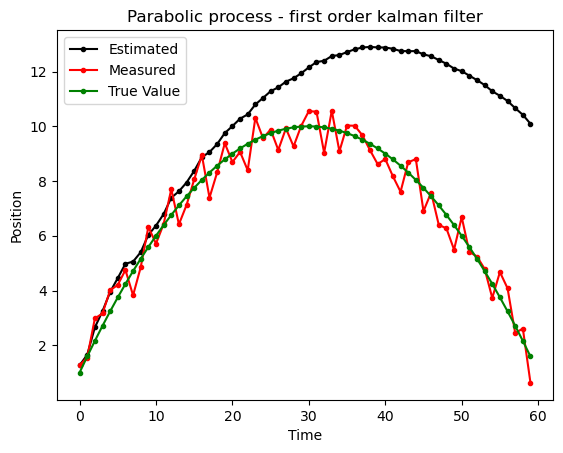

In [61]:
plt.plot(df_para.index, np.stack((df_para['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.plot(steps, para_measure ,marker=".",color="red")
plt.plot(steps, para_gt ,marker=".",color="g")
plt.title("Parabolic process - first order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.show()

The first order kalman filter shows a significant overshoot as well as a lag in responce. Q is purposefully set low, it emphesiszes the prediction step. The filter does not work well

#### Parabolic process with second order filter

In [62]:
delta_t = 1

In [63]:
X0 = np.array([0,0,0])  # Level, Filling rate
P0 = np.array([[1000,    0,   0],
               [0   , 1000,   0],
               [0   ,    0,1000]])  # Assume no correlation between states
F = np.array([[1, delta_t, 0.5*delta_t**2], 
              [0,       1,        delta_t],
              [0,       0,              1]])
r = 0.3
q = 0.0000001
Q = q*np.array([[(delta_t**4)/4,(delta_t**3)/2,(delta_t**2)/2],
                [(delta_t**3)/2,  (delta_t)**2,       delta_t],
                [(delta_t**2)/2,       delta_t,              1]])
H = np.array([1, 0, 0])

In [64]:
testFilter_para2 = MyKalmanFilterHigherOrder(X0, P0, r, Q, F, H)

In [65]:
#%%capture
xt_intr_list = []
Pt_intr_list = []
k_gain_list = []
xt_curr_list = []
Pt_curr_list = []

for measure in para_measure:
    testFilter_para2.step(measure);
    
    # Record time steps    
    xt_intr_list.append(testFilter_para2.xt_intr)
    Pt_intr_list.append(testFilter_para2.Pt_intr)
    k_gain_list.append(testFilter_para2.k_gain)
    xt_curr_list.append(testFilter_para2.xt_curr)
    Pt_curr_list.append(testFilter_para2.Pt_curr)

In [66]:
list_of_lists = [xt_intr_list,Pt_intr_list,k_gain_list,xt_curr_list,Pt_curr_list]
df_para2 = pd.DataFrame(list(zip(*list_of_lists)), columns= ['xt_intr','Pt_intr','k_gain','xt_curr','Pt_curr'])

In [67]:
df_para2

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,"[0.0, 0.0, 0.0]","[[2250.000000025, 1500.00000005, 500.00000005]...","[0.9998666844420758, 0.6665777896428633, 0.222...","[1.2680427014468465, 0.84536180098335, 0.28178...","[[0.2999600053327245, 0.19997333689292685, 0.0..."
1,"[2.2542981359368146, 1.1271490679965859, 0.281...","[[1.1998400463708927, 0.7998933975983705, 0.26...","[0.7999786705749731, 0.5333191359530923, 0.177...","[1.6926985532519352, 0.7527493305962782, 0.156...","[[0.2399936011724919, 0.1599957407859277, 0.05..."
2,"[2.5239415533183327, 0.9097366695365168, 0.156...","[[0.8066452477157626, 0.43998838967356657, 0.1...","[0.7289104158543734, 0.3975875652850369, 0.108...","[2.855792531684086, 1.0907463240236837, 0.2063...","[[0.218673124756312, 0.11927626958551106, 0.03..."
3,"[4.049715671101435, 1.297099954811014, 0.20635...","[[0.5855381209138922, 0.26023928838487226, 0.0...","[0.6612229412660471, 0.2938770022868134, 0.065...","[3.463275450241686, 1.036459732926551, 0.14843...","[[0.1983668823798141, 0.08816310068604398, 0.0..."
4,"[4.573951935276572, 1.1848932371432208, 0.1484...","[[0.44632576400021196, 0.1653060349255453, 0.0...","[0.5980307601977483, 0.22149313731248646, 0.04...","[4.235910313902833, 1.0596924878782317, 0.1252...","[[0.1794092280593244, 0.06644794119374592, 0.0..."
5,"[5.358226851938081, 1.184940588192263, 0.12524...","[[0.3553734551142305, 0.11222349846674878, 0.0...","[0.542245726220769, 0.1712359534720374, 0.0270...","[4.73322708946242, 0.9875717108140689, 0.09408...","[[0.16267371786623072, 0.05137078604161123, 0...."
6,"[5.767840971922231, 1.0816560541055529, 0.0940...","[[0.29301615375014906, 0.08043625854412775, 0....","[0.4941115885244558, 0.13563923686641655, 0.01...","[5.265557571493586, 0.9437735621602377, 0.0751...","[[0.14823347655733674, 0.040691771059924955, 0..."
7,"[6.246910619820421, 1.0189325344934324, 0.0751...","[[0.2482536222434636, 0.06018335319840231, 0.0...","[0.45280799281837003, 0.10977283278518245, 0.0...","[5.149926547115075, 0.7529940990175488, 0.0429...","[[0.13584239784551097, 0.03293184983555473, 0...."
8,"[5.9243821086757, 0.7959170241037009, 0.042922...","[[0.21483578953450486, 0.04659182522410243, 0....","[0.4172899279763579, 0.09049841944016558, 0.00...","[5.476613236161011, 0.6988085809797628, 0.0323...","[[0.12518697839290735, 0.02714952583204967, 0...."
9,"[6.191618035936882, 0.7312010185719796, 0.0323...","[[0.1890636724848932, 0.037072597160960355, 0....","[0.3865829402627185, 0.07580321182433662, 0.00...","[6.243086108781776, 0.7412931484145446, 0.0333...","[[0.11597488207881554, 0.02274096354730099, 0...."


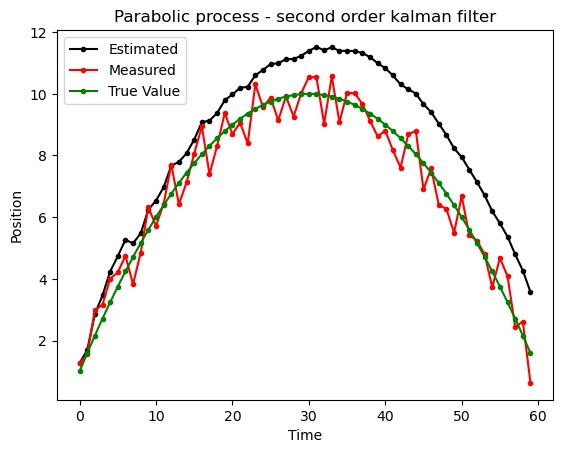

In [68]:
plt.plot(df_para2.index, np.stack((df_para2['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.plot(steps, para_measure ,marker=".",color="red")
plt.plot(steps, para_gt ,marker=".",color="g")
plt.title("Parabolic process - second order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.show()

Second order filter works significantly better

#### Parabolic process with drag using second order filter

In [69]:
steps = np.arange(60)
drag_gt = 10 + steps-10*2**(steps*0.05)
drag_measure = drag_gt+5*(np.random.rand(drag_gt.shape[0])-0.5)

In [70]:
delta_t = 1

In [71]:
X0 = np.array([0,0,0])  # Level, Filling rate
P0 = np.array([[1000,    0,   0],
               [0   , 1000,   0],
               [0   ,    0,1000]])  # Assume no correlation between states
F = np.array([[1, delta_t, 0.5*delta_t**2], 
              [0,       1,        delta_t],
              [0,       0,              1]])
r = 0.3
q = 0.0000001
Q = q*np.array([[(delta_t**4)/4,(delta_t**3)/2,(delta_t**2)/2],
                [(delta_t**3)/2,  (delta_t)**2,       delta_t],
                [(delta_t**2)/2,       delta_t,              1]])
H = np.array([1, 0, 0])

In [72]:
testFilter_para2 = MyKalmanFilterHigherOrder(X0, P0, r, Q, F, H)

In [73]:
#%%capture
xt_intr_list = []
Pt_intr_list = []
k_gain_list = []
xt_curr_list = []
Pt_curr_list = []

for measure in drag_measure:
    testFilter_para2.step(measure);
    
    # Record time steps    
    xt_intr_list.append(testFilter_para2.xt_intr)
    Pt_intr_list.append(testFilter_para2.Pt_intr)
    k_gain_list.append(testFilter_para2.k_gain)
    xt_curr_list.append(testFilter_para2.xt_curr)
    Pt_curr_list.append(testFilter_para2.Pt_curr)

In [74]:
list_of_lists = [xt_intr_list,Pt_intr_list,k_gain_list,xt_curr_list,Pt_curr_list]
df_para2 = pd.DataFrame(list(zip(*list_of_lists)), columns= ['xt_intr','Pt_intr','k_gain','xt_curr','Pt_curr'])

In [75]:
df_para2

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,"[0.0, 0.0, 0.0]","[[2250.000000025, 1500.00000005, 500.00000005]...","[0.9998666844420758, 0.6665777896428633, 0.222...","[-0.12405475983847647, -0.08270317322748882, -...","[[0.2999600053327245, 0.19997333689292685, 0.0..."
1,"[-0.2205417952714657, -0.11027089763848962, -0...","[[1.1998400463708927, 0.7998933975983705, 0.26...","[0.7999786705749731, 0.5333191359530923, 0.177...","[-1.4008284945530907, -0.8971287299671709, -0....","[[0.2399936011724919, 0.1599957407859277, 0.05..."
2,"[-2.4428840751799696, -1.1869824312865873, -0....","[[0.8066452477157626, 0.43998838967356657, 0.1...","[0.7289104158543734, 0.3975875652850369, 0.108...","[1.7006806514144617, 1.0731441568575093, 0.326...","[[0.218673124756312, 0.11927626958551106, 0.03..."
3,"[2.937097177918502, 1.3996888961505711, 0.3265...","[[0.5855381209138922, 0.26023928838487226, 0.0...","[0.6612229412660471, 0.2938770022868134, 0.065...","[0.8936553343447398, 0.4914920901125399, 0.124...","[[0.1983668823798141, 0.08816310068604398, 0.0..."
4,"[1.4475089032664972, 0.6162150477309748, 0.124...","[[0.44632576400021196, 0.1653060349255453, 0.0...","[0.5980307601977483, 0.22149313731248646, 0.04...","[0.8487343368520922, 0.39444642630722737, 0.08...","[[0.1794092280593244, 0.06644794119374592, 0.0..."
5,"[1.2850080395343397, 0.4781009790572679, 0.083...","[[0.3553734551142305, 0.11222349846674878, 0.0...","[0.542245726220769, 0.1712359534720374, 0.0270...","[3.5173003275279866, 1.1830372835386056, 0.194...","[[0.16267371786623072, 0.05137078604161123, 0...."
6,"[4.797818200165111, 1.3779984617356429, 0.1949...","[[0.29301615375014906, 0.08043625854412775, 0....","[0.4941115885244558, 0.13563923686641655, 0.01...","[4.557274808595475, 1.3119665717263476, 0.1858...","[[0.14823347655733674, 0.040691771059924955, 0..."
7,"[5.9621902917726874, 1.4978643946280767, 0.185...","[[0.2482536222434636, 0.06018335319840231, 0.0...","[0.45280799281837003, 0.10977283278518245, 0.0...","[5.9098252968496245, 1.4851697118427574, 0.184...","[[0.13584239784551097, 0.03293184983555473, 0...."
8,"[7.48717451952366, 1.6695287335053144, 0.18435...","[[0.21483578953450486, 0.04659182522410243, 0....","[0.4172899279763579, 0.09049841944016558, 0.00...","[5.342653491638339, 1.2044425896317041, 0.1339...","[[0.12518697839290735, 0.02714952583204967, 0...."
9,"[6.614058506623939, 1.3383674403394972, 0.1339...","[[0.1890636724848932, 0.037072597160960355, 0....","[0.3865829402627185, 0.07580321182433662, 0.00...","[6.943046109837104, 1.4028770561983874, 0.1402...","[[0.11597488207881554, 0.02274096354730099, 0...."


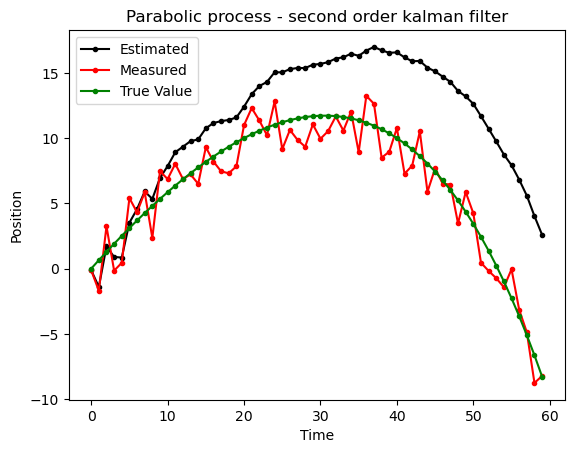

In [76]:
plt.plot(df_para2.index, np.stack((df_para2['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.plot(steps, drag_measure ,marker=".",color="red")
plt.plot(steps, drag_gt ,marker=".",color="g")
plt.title("Parabolic process - second order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.show()

Second order filter does not capture the non-linear shape well

## More theory

#### Extended Kalman filter

For a nonlinear dynamic system - one is not able to define either or both the process model or measurement model with multiplication of vectors and matrices. In an EKF we linearize the models about a current estimate using first order Taylor series expansion.

A nonlinear process model:

$x_k=f(x_{k−1},u_{k−1})+w_{k}$ <br>
$z_k=h(x_{k})+{\upsilon}_k$


The Jacobian matrix is a matrix containing the first-order partial derivatives of a function. Jacobian is the best linear approximation of the true gradient at a specific point.  Unless a linear function with and constant slope, the Jacobian will differ from point to point. 

#### Parabolic process with drag and second order filter

For severly nonlinear systems - an unscented kalman filter (UKF) may work better.

## Sensor fusion

There are various approaches that can be taken to fuse sensors. Some are:
- Merge with observation matrix
- Combine with minimum meansquare estimates
- Correction step performed per each sensor arrival -> Useful when at different sampling rates

#### Merge with observation matrix

Suppose you have two measurements for the state: <br>
$z = [x_A,x_B]^T $

The matrix H converts x to z measurements: <br>
$z_t=Hx_{t}$